In [1]:
# load general packages
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import numba as nb

# Import user package
import functions as funcs

## Uncomment for nicer plots ##
plt.rc('font', family='serif')
plt.rc('text', usetex=True)
plt.rc('axes', axisbelow=True)

In [2]:
# Set seed once
np.seed = 200

In [3]:
N = 10_000_000
alpha = 1.2
mu = -0.3

rand = np.random.uniform(0,1, size=N)
x = mu + (1 - rand)**(-1/alpha)

In [4]:
P = 0.005
u = np.percentile(x,100*(1-P))
u

82.23175118081943

In [8]:
# Compute u when P = 0.01
# i.e. the 99th percentile of the distribution
P = 0.01
u = np.percentile(x,100*(1-P))

# Compute S
x_low = x[x<u]
E_low = np.mean(x[x<u])
S = alpha/(alpha-1)*u*P / (alpha/(alpha-1)*u*P + E_low * (1-P))

In [9]:
# Compute Gini of top group
G_top = 1/(2*alpha-1)

Optimal function for gini coefficient here

In [13]:
def gini(x, w=None):
    # The rest of the code requires numpy arrays.
    x = np.asarray(x)
    if w is not None:
        w = np.asarray(w)
        sorted_indices = np.argsort(x)
        sorted_x = x[sorted_indices]
        sorted_w = w[sorted_indices]
        # Force float dtype to avoid overflows
        cumw = np.cumsum(sorted_w, dtype=float)
        cumxw = np.cumsum(sorted_x * sorted_w, dtype=float)
        return (np.sum(cumxw[1:] * cumw[:-1] - cumxw[:-1] * cumw[1:]) / 
                (cumxw[-1] * cumw[-1]))
    else:
        sorted_x = np.sort(x)
        n = len(x)
        cumx = np.cumsum(sorted_x, dtype=float)
        # The above formula, with all weights equal to 1 simplifies to:
        return (n + 1 - 2 * np.sum(cumx) / cumx[-1]) / n

In [84]:
# Test loop
reps = 10_000
n = 50_000
u_vec = np.zeros(shape=reps)
alpha_hat = np.zeros(shape=reps)

alpha = 1.5
mu = 0

for rep in range(reps):
    
    # Draw values
    rand = np.random.uniform(0,1, size=n)
    x = mu + (1 - rand)**(-1/alpha)
    
    # Estimate tail
    P = 0.01
    u = np.percentile(x,100*(1-P))
    
    N_1 = np.size(x[x>=u])    
    alpha_hat[rep] = N_1 / (np.sum(np.log(x[x>u])) - N_1*np.log(u))

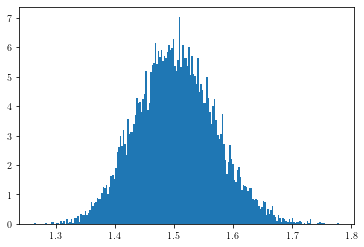

In [85]:
plt.hist(alpha_hat, bins=200, density=True)
plt.show()

In [88]:
stats.skew(alpha_hat)

0.15340179876681187

**Run Monte Carlo experiment from here**

Monte Carlo experiment for the non-parametric and semi-parametric estimator

In [3]:
# Set Monte Carlo parameters
reps = 10_000
n = 50_000

For $\alpha = 1.5$

In [5]:
# Set distribution parameters
alpha_1 = 1.5
mu = 0.0

# Initialize
G_vec_1 = np.zeros(shape=reps)
G_nonparam_vec_1 = np.zeros(shape=reps)

# Loop over replications for now
for rep in range(reps):
    
    # Draw values
    rand = np.random.uniform(0,1, size=n)
    x = mu - 1 + (1 - rand)**(-1/alpha_1)
    
    # Compute p
    P = 0.01
    u = np.percentile(x,100*(1-P))

    # Estmate alpha
    N_1 = np.size(x[x>=u])    
    alpha_hat = N_1 / (np.sum(np.log(x[x>u])) - N_1*np.log(u))
    
    # Compute S
    x_low = x[x<u] # Is this needed?
    E_low = np.mean(x[x<u])
    S = alpha_hat/(alpha_hat-1)*u*P / (alpha_hat/(alpha_hat-1)*u*P + E_low * (1-P))
    S_alvaredo = np.mean(x[x>=u]) / (np.mean(x[x>=u]) + E_low) # Numerical top income share

    # Compute the Gini coefficients with both methods
    G_high = 1/(2*alpha_hat-1)
    G_low = funcs.gini(x[x<u])
    
    G = G_high*P*S + G_low*(1-P)*(1-S) + S - P
    G_nonparam = funcs.gini(x)
    
    # Save values
    G_vec_1[rep] = G
    G_nonparam_vec_1[rep] = G_nonparam

Plot the results

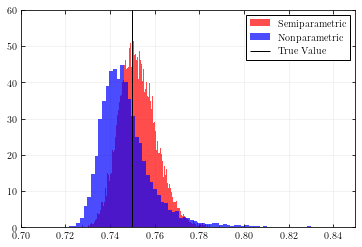

In [9]:
# Compute the true gini
eta_1 = mu-1 + alpha_1/(alpha_1-1)
G_true_1 = 1 - 2/eta_1 * ( (mu-1)/2 + alpha_1/(alpha_1-1)*(1 - alpha_1/(2*alpha_1-1)))

fig = plt.figure(figsize=(6,4))
ax = fig.add_subplot(1,1,1)

ax.grid(b=True, which = 'major', linestyle='-', linewidth=0.5, color='0.9', zorder=0)
ax.tick_params(axis='both', bottom=True, top=True, left=True, right=True, direction='in', which='both')

ax.hist(G_vec_1, density = True, bins = 150, color = 'red', alpha = 0.7, zorder = 2, label='Semiparametric', histtype='stepfilled')
ax.hist(G_nonparam_vec_1, density = True, bins = 150, color = 'blue', alpha = 0.7, zorder = 2, label='Nonparametric', histtype='stepfilled')

ax.vlines(G_true_1, ymin=0,ymax=100, linestyle = '-', linewidth = 1.0, label='True Value', zorder=3)
ax.set_ylim(0,60)
ax.set_xlim(0.7,.85)

ax.legend(frameon = True, edgecolor = 'k', facecolor = 'white', framealpha=1, fancybox=False)

plt.savefig('../../tex/figs/estimator_15.pdf')

Compute summary statistics

In [27]:
print('Nonparam bias = ' + str(np.mean(G_nonparam_vec_1) - G_true_1))
print('Semiparam bias = ' + str(np.mean(G_vec_1) - G_true_1))

print('Nonparam variance = ' + str(np.std(G_nonparam_vec_1)))
print('Semiparam variance = ' + str(np.std(G_vec_1)))

print('Nonparam skewness = ' + str(stats.skew(G_nonparam_vec_1)))
print('Semiparam skewness = ' + str(stats.skew(G_vec_1)))

Nonparam bias = -0.0019315233423887745
Semiparam bias = 0.0026017001718393606
Nonparam variance = 0.015346397986039617
Semiparam variance = 0.008484906423004698
Nonparam skewness = 4.1443471822848545
Semiparam skewness = 0.4281836944663952


In [28]:
stats.mode(G_vec_1)

ModeResult(mode=array([0.7273639]), count=array([1]))

For $\alpha = 1.2$

In [15]:
# Set distribution parameters
alpha_2 = 1.2
mu = 0.0

# Initialize
G_vec_2 = np.zeros(shape=reps)
G_nonparam_vec_2 = np.zeros(shape=reps)

# Loop over replications for now
for rep in range(reps):
    
    # Draw values
    rand = np.random.uniform(0,1, size=n)
    x = mu - 1 + (1 - rand)**(-1/alpha_2)
    
    # Compute p
    P = 0.01
    u = np.percentile(x,100*(1-P))

    # Estmate alpha
    N_1 = np.size(x[x>=u])    
    alpha_hat = N_1 / (np.sum(np.log(x[x>u])) - N_1*np.log(u))
    
    # Compute S
    x_low = x[x<u] # Is this needed?
    E_low = np.mean(x[x<u])
    S = alpha_hat/(alpha_hat-1)*u*P / (alpha_hat/(alpha_hat-1)*u*P + E_low * (1-P))
    S_alvaredo = np.mean(x[x>=u]) / (np.mean(x[x>=u]) + E_low) # Numerical top income share

    # Compute the Gini coefficients with both methods
    G_high = 1/(2*alpha_hat-1)
    G_low = funcs.gini(x[x<u])
    
    G = G_high*P*S + G_low*(1-P)*(1-S) + S - P
    G_nonparam = funcs.gini(x)
    
    # Save values
    G_vec_2[rep] = G
    G_nonparam_vec_2[rep] = G_nonparam

Plot the results

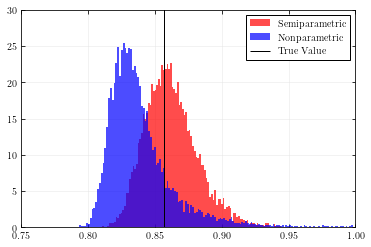

In [21]:
# Compute the true gini
eta_2 = mu-1 + alpha_2/(alpha_2-1)
G_true_2 = 1 - 2/eta_2 * ( (mu-1)/2 + alpha_2/(alpha_2-1)*(1 - alpha_2/(2*alpha_2-1)))

fig = plt.figure(figsize=(6,4))
ax = fig.add_subplot(1,1,1)

ax.grid(b=True, which = 'major', linestyle='-', linewidth=0.5, color='0.9', zorder=0)
ax.tick_params(axis='both', bottom=True, top=True, left=True, right=True, direction='in', which='both')

ax.hist(G_vec_2, density = True, bins = 150, color = 'red', alpha = 0.7, zorder = 2, label='Semiparametric', histtype='stepfilled')
ax.hist(G_nonparam_vec_2, density = True, bins = 150, color = 'blue', alpha = 0.7, zorder = 2, label='Nonparametric', histtype='stepfilled')

ax.vlines(G_true_2, ymin=0,ymax=100, linestyle = '-', linewidth = 1.0, label='True Value', zorder=3)
ax.set_ylim(0,30)
ax.set_xlim(0.75,1)

ax.legend(frameon = True, edgecolor = 'k', facecolor = 'white', framealpha=1, fancybox=False)

plt.savefig('../../tex/figs/estimator_12.pdf')

In [29]:
print('Nonparam bias = ' + str(np.mean(G_nonparam_vec_2) - G_true_2))
print('Semiparam bias = ' + str(np.mean(G_vec_2) - G_true_2))

print('Nonparam variance = ' + str(np.std(G_nonparam_vec_2)))
print('Semiparam variance = ' + str(np.std(G_vec_2)))

print('Nonparam skewness = ' + str(stats.skew(G_nonparam_vec_2)))
print('Semiparam skewness = ' + str(stats.skew(G_vec_2)))

Nonparam bias = -0.017610955353194124
Semiparam bias = 0.00557762406587925
Nonparam variance = 0.025449297286362114
Semiparam variance = 0.02013672400129087
Nonparam skewness = 2.0608338565175117
Semiparam skewness = 0.7427053728587425


Some test code below here

In [395]:
# Lorenz curve for Pareto type II
def lorenz(F):
    
    denom = mu-1 + alpha /(alpha-1)
    nom = F*(mu-1) + alpha/(alpha-1)*(1-(1-F)**(1-1/alpha))
    
    return nom/denom

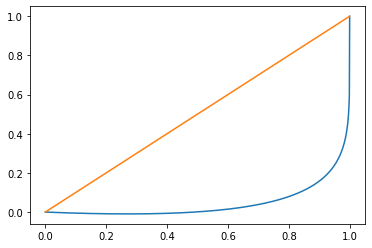

In [396]:
temp = np.linspace(0,1,1000)
lorenz_val = lorenz(temp)

plt.plot(temp,lorenz_val)
plt.plot(temp,temp)

In [104]:
mu = 0.00
alpha = 1.5
eta = mu-1 + alpha/(alpha-1)

G_true = 1 - 2/eta * ( (mu-1)/2 + alpha/(alpha-1)*(1 - alpha/(2*alpha-1)))
G_true

0.75

Compute Gini numerically

In [410]:
d = 1000000

vals = np.linspace(0,1,d)
dF = 1/d
lorenz_vals = lorenz(vals)

lorenz_int = np.sum(lorenz_vals*dF)

gini_num = 1 - 2*lorenz_int
gini_num

0.8623158058581297

It fits